<center><font size = "10"> Week 1 <center>
<center><font size = "8"> Tutorial 03: Integrate-and-Fire neuron <center>


<font size="4" color="red"> In this tutorial you can learn a simple way of modelling the activity of one single neuron, run a simulation, visualize its activty and perform some simple analysis.

<font size="4" color="red">If you are not familiar with the Python programming language, make sure you do Tutorials 1 and 2 first!

In [1]:
# First we will import the various software libraries we will use in this tutorial
import numpy as np
import matplotlib.pyplot as plt
from neuron import h   # NEURON simulator
_ = h.Section()  # NEURON always requires at least one section, so we make it, but we're not going to use it

Matplotlib is building the font cache; this may take a moment.
--No graphics will be displayed.


# Simulating a point-neuron model

The [NEURON](https://neuron.yale.edu/neuron/) simulator provides many tools for simulating networks of neurons, especially biophysically detailed neurons.

Today however, we will be using a simplified neuron model called a point-neuron models without detailed biophysics. These neurons are a lot more efficient to run on a computer and are simpler to work with, at the cost of detail and accuracy.

Integrate-and-Fire neuron models are a commonly used form of point-neuron model.
See : https://neuronaldynamics.epfl.ch/online/Ch1.S3.html for the technical details.

NEURON supports several of these types of neuron out of the box, the simplest of which is [h.IntFire1()](https://www.neuron.yale.edu/neuron/static/py_doc/modelspec/programmatic/mechanisms/mech.html#IntFire1)

In [2]:
neuron1 = h.IntFire1()

## Parameterization

The IntFire1 neuron model has two parameters and one variable: the membrane time constant tau, the refractory period refrac, and the membrane potential m.


A neuron has a cell membrane, separating the (intracellular) fluid inside from the (extracellular) fluid outside.
The difference in electrical potential accross the membrane (inside vs. outside) is called the membrane potential.

When electrically charged ions traverse the membrane through ion channels (in biology), the neuron's membrane potential changes. 
At rest (in the abscense of synaptic activations), the traversal of ions across the membrance brings the cell's membrane potential back to what is called its resting potential (usually around -70mV).
The membrane time constant is a measure of how long it takes for the membrane potential to decay halfway back to the resting potential (i.e. the half-life).

When something depolarizes (increases) the membrane potential above a certain value (called the threshold), ion channels in the cell open and the membrane potential increases further: the cell fires an action potential.
After the sharp increase, the membrane potential repolarizes (decreases), and the cell cannot fire an action potential for a short period of time (known as the refractory period).

Note that IntFire1 uses a resting potential of 0 and a threshold of 1.

In [3]:
neuron1.tau = 10 # membrane time constant (ms)
neuron1.refrac = 5  # refractory pertiod (ms)

## Stimulation

To see how this artificial neuron responds to changes in voltage, we are going to stimulate it with instantaneous increases in membrane potential.
h.NetStim provides a stimulus that acts at regular intervals.
We then connect this stimulus to the neuron with a certain weight, which determines the size of the increase in membrane potential.

In [4]:
regular_stimulus1 = h.NetStim()
regular_stimulus1.interval = 4 # milliseconds between spikes
regular_stimulus1.number = 20 # number of spikes
regular_stimulus1.start = 5 # time in milliseconds when the stimulus starts
conn1 = h.NetCon(regular_stimulus1, neuron1)
conn1.weight[0] = 0.4 # strength of the effect of each spike: IntFire1 uses a resting potential of 0 and a threshold of 1, so a weight of 0.4 means that one event gets it 40% of the way to the threshold

## Running a simulation

First, we create h.Vector objects which will record and store the value of variables as our simulation runs

In [5]:
time = h.Vector()
time.record(h._ref_t)  # remember `_ = h.Section()` from the first code block? this only works if we have done that.

input_event_times = h.Vector()
conn1.record(input_event_times)

outconn = h.NetCon(neuron1, None)  # necessary to record neuron1's action potentials
output_event_times = h.Vector()
outconn.record(output_event_times)

0.0

1. Calculate the length of the stimulus train
2. Initialize our model
3. Run our simulation by stepping through one timestep at a time, and recording the neurons membrane potential on each step

In [6]:
stimulus_duration = regular_stimulus1.number * regular_stimulus1.interval + regular_stimulus1.start
nsteps = int(np.ceil(stimulus_duration / h.dt))
h.finitialize()  # initialize the model

Vm_neuron1 = [neuron1.M()]  # IntFire does not explicitly store membrane potential. We cannot record it with Vector.record(neuron1._ref_m), so we have to record it as we go
for step in range(nsteps):
    h.fadvance()
    Vm_neuron1.append(neuron1.M())
Vm_neuron1 = np.array(Vm_neuron1)

## Visualization and analysis
Now we make a simple plot to see the evolution of the model over time.

Text(0, 0.5, '$V_m$ (mV)')

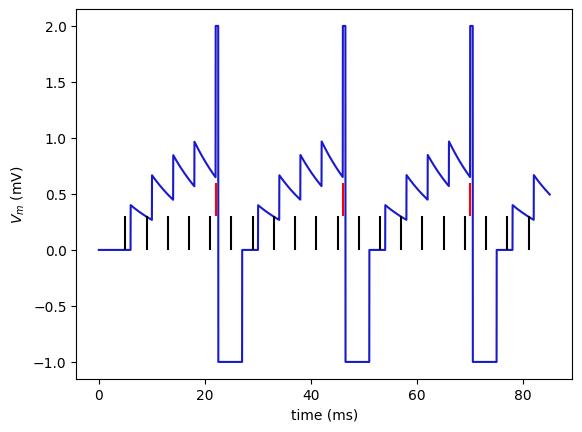

In [8]:
f, ax = plt.subplots()
ax.plot(time, Vm_neuron1, color=[0.1, 0.1, 0.8])  # creates a blue plot of membrane potential over time
ax.vlines(np.array(input_event_times), ymax=0.3, ymin=0, color='k')  # creates vertical black lines
ax.vlines(np.array(output_event_times), ymax=0.6, ymin=0.3, color='r')  # creates vertical red lines
plt.xlabel('time (ms)')
plt.ylabel('$V_m$ (mV)')

We can also quantify properties of the neuron's response to the stimulus.

One example is the mean firing rate (the number of action potentials fired per unit time).

In [9]:
def mean_firing_rate(output_event_times, time):
    return (len(output_event_times) / max(time)) * 1000  # spikes per second 

mean_firing_rate(output_event_times, time)


35.29411764705436

Let's have a look at how this mean firing rate changes with the weight of the stimulus.

In [10]:
def run_sim():
    """
    Rerun the simulation with any changes made to the neuron model and return the membrane potential
    """

    stimulus_duration = regular_stimulus1.number * regular_stimulus1.interval + regular_stimulus1.start
    nsteps = int(np.ceil(stimulus_duration / h.dt))
    h.finitialize() 

    Vm_neuron1 = [neuron1.M()]
    for step in range(nsteps):
        h.fadvance()
        Vm_neuron1.append(neuron1.M())
    Vm_neuron1 = np.array(Vm_neuron1)
    return Vm_neuron1

82.35294117646016

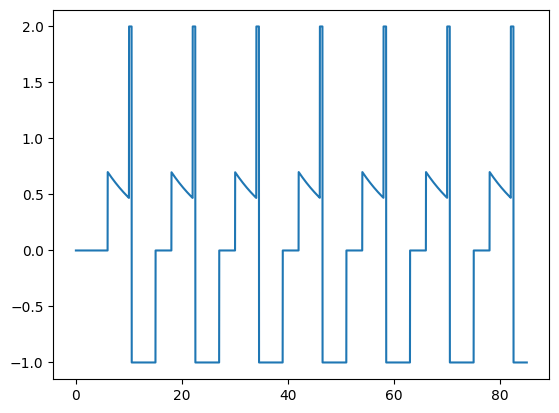

In [11]:
conn1.weight[0] = 0.7
Vm = run_sim()
plt.plot(time, Vm)
mean_firing_rate(output_event_times, time)

As you would expect, it spikes faster now

0.0

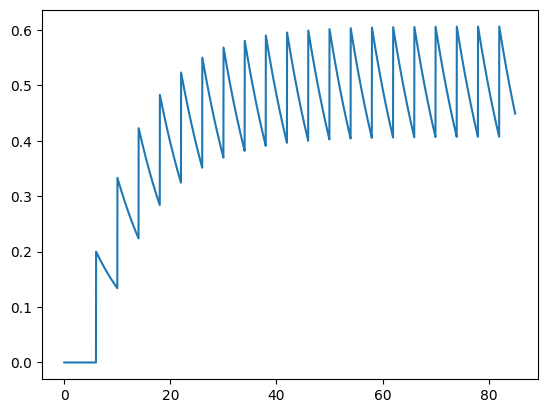

In [12]:
conn1.weight[0] = 0.2
Vm = run_sim()
plt.plot(time, Vm)
mean_firing_rate(output_event_times, time)

Now it isn't spiking at all

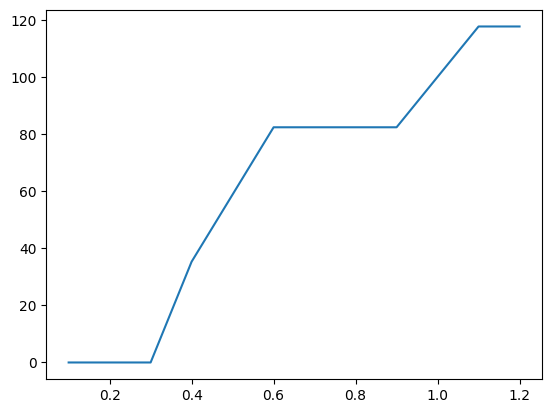

In [13]:
weights = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.1, 1.2]
rates = []
for weight in weights:
    conn1.weight[0] = weight
    Vm = run_sim()
    rates.append(mean_firing_rate(output_event_times, time))
    
plt.plot(weights, rates)